In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

import cv2
from src.utils.func import (crop_center, read_image_as_numpyimage, 
    pipette_color, apply_pht, _convert_hough_segments_to_lines,
    group_lines, crop_image_by_points, transform_line)
from src.utils.plotting import display_img
from src.utils.playfield_finder import PlayfieldFinder
import matplotlib.pyplot as plt
import numpy as np
from src.utils.lines import Line
from src.utils.points import Point

plt.rcParams['image.cmap'] = 'gray'

In [ ]:
pic = read_image_as_numpyimage('/home/polymorvic/development/deep-peep-snooker/pics/runda_9/pic_09_31_02.png', 'rgb') # pic_02_07_01.png   pic_05_18_01.png # runda_8/pic_08_08_01.png'
cropped_pic = crop_center(pic)

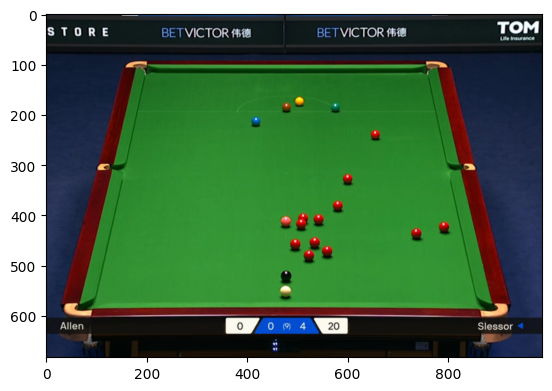

In [3]:
plt.imshow(pic)

In [4]:
finder = PlayfieldFinder(pic)

In [5]:
cushions = finder.find_side_cushions()

In [6]:
# img = cushions['top_left'][0]

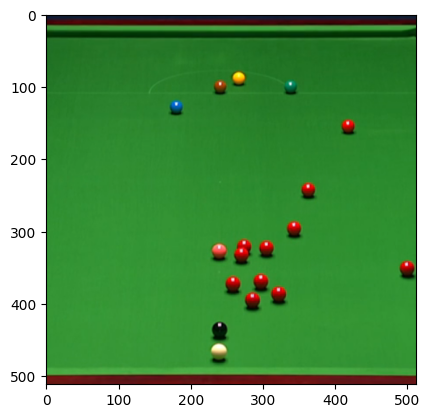

In [7]:
plt.imshow(cropped_pic)

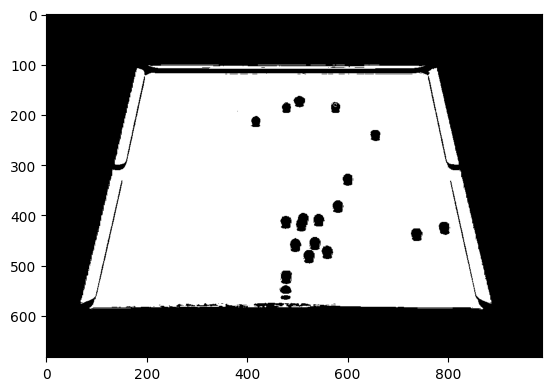

In [8]:
pic_hsv = cv2.cvtColor(pic, cv2.COLOR_RGB2HSV)
cropped_pic_hsv = cv2.cvtColor(cropped_pic, cv2.COLOR_RGB2HSV)

dominant_color = pipette_color(cropped_pic_hsv)

h, s, v = dominant_color
h_std = np.std(cropped_pic_hsv[:, :, 0])
s_std = np.std(cropped_pic_hsv[:, :, 1])
v_std = np.std(cropped_pic_hsv[:, :, 2])

h_tolerance = int(h_std * 1.5)
s_tolerance = int(s_std * 1.5)
v_tolerance = int(v_std * 1.5)

lower_bound = np.array([max(0, h - h_tolerance), 
                       max(0, s - s_tolerance), 
                       max(0, v - v_tolerance)])

upper_bound = np.array([min(179, h + h_tolerance), 
                       min(255, s + s_tolerance), 
                       min(255, v + v_tolerance)])

binary_mask = cv2.inRange(pic_hsv, lower_bound, upper_bound)

plt.imshow(binary_mask)
plt.show()

In [9]:
inv_binary_img = cv2.bitwise_not(binary_mask)

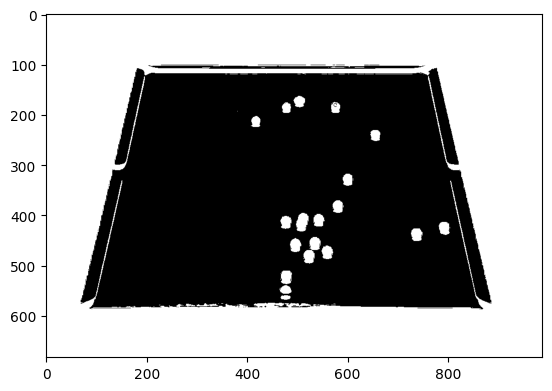

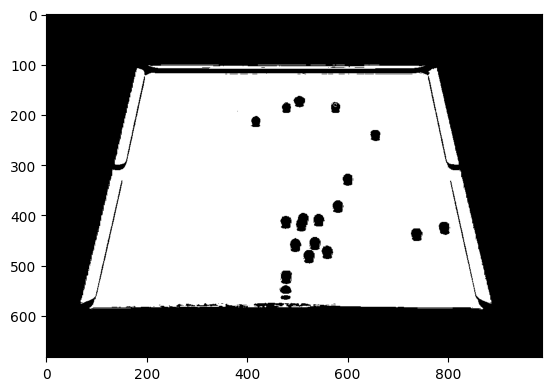

In [10]:
plt.imshow(inv_binary_img)
plt.show()
plt.imshow(binary_mask)

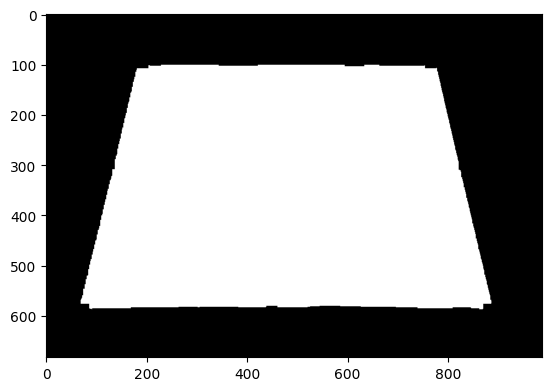

In [11]:
binary_mask_close = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((21, 21), np.uint8))
plt.imshow(binary_mask_close)

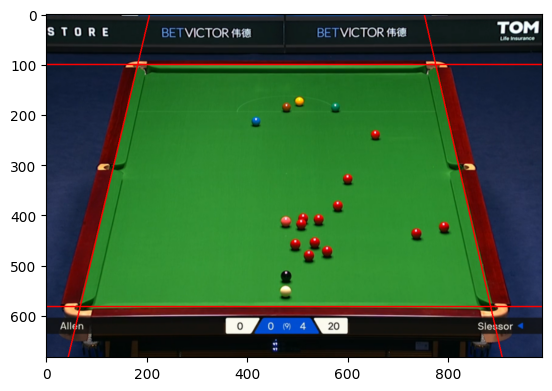

In [12]:
edges = cv2.Canny(binary_mask_close, 150, 200)

segments = cv2.HoughLinesP(
    edges, 
    1, 
    np.pi / 180, 
    threshold=100, 
    minLineLength=100, 
    maxLineGap=10
)

lines = _convert_hough_segments_to_lines(segments)
lines = group_lines(lines, thresh_theta=5, thresh_intercept=100)

pic_copy = pic.copy()
for line in lines:
    pts = line.limit_to_img(pic_copy)
    cv2.line(pic_copy, *pts, (255, 0, 0), 2)

plt.imshow(pic_copy)

In [13]:
intersections = set()
for group1 in lines:
    for group2 in lines:
        intersection = group1.intersection(group2, pic_copy)
        if intersection is not None:
            intersections.add(intersection)
            
intersections = list(intersections)
intersection_points = np.array([[int(inter.point.x), int(inter.point.y)] for inter in intersections])

In [14]:
intersection_points

array([[776, 100],
       [182, 100],
       [886, 582],
       [ 68, 582]])

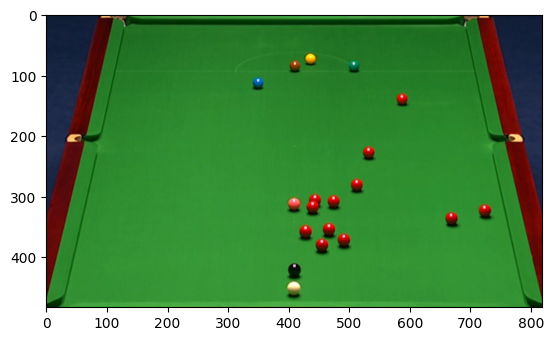

(68, 100)

In [15]:
cropped_by_points, x_start, y_start = crop_image_by_points(pic, intersection_points)
display_img(cropped_by_points)
x_start, y_start 

In [16]:
h, w = cropped_by_points.shape[:2]
roi = cropped_by_points[int(0.9*h):] 

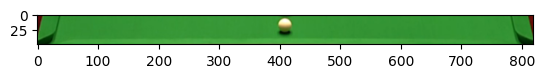

In [17]:
display_img(roi)

In [18]:
hsv_img = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_img)

In [19]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
v_eq = clahe.apply(v)

In [20]:
v_eq

array([[ 71,  78,  78, ...,  95, 100, 100],
       [ 71,  78,  78, ...,  98, 108, 105],
       [ 71,  75,  78, ...,  98, 108, 105],
       ...,
       [ 39,  42,  44, ...,  47,  52,  54],
       [ 41,  44,  41, ...,  44,  49,  51],
       [ 38,  38,  38, ...,  41,  44,  46]], shape=(49, 819), dtype=uint8)

In [21]:
v_blur = cv2.GaussianBlur(v_eq, (9, 9), 0)

In [22]:
grad_y = cv2.Sobel(v_blur, cv2.CV_32F, dx=0, dy=1, ksize=3)
grad_y = np.abs(grad_y)

In [23]:
row_response_p = np.percentile(grad_y, 90, axis=1).astype(np.float32)

In [24]:
k = 21  
x = np.linspace(-3, 3, k).astype(np.float32)
g = np.exp(-(x**2) / 2).astype(np.float32)
g /= g.sum()
row_response_smooth = np.convolve(row_response_p, g, mode="same")

edge_row2 = int(np.argmax(row_response_smooth))

h_c, w_c = cropped_by_points.shape[:2]
roi_y0 = int(0.9 * h_c)     
edge_y_in_cropped = roi_y0 + edge_row2

edge_y_in_pic = int(y_start + edge_y_in_cropped)

In [25]:
internal_bottom_cushion = Line.from_points(Point(0, edge_y_in_pic), Point(w_c, edge_y_in_pic))

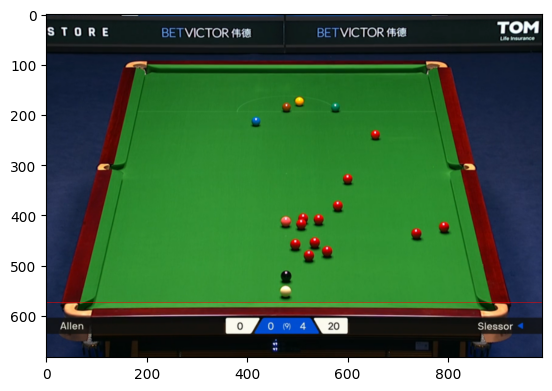

In [27]:
pic_copy2 = pic.copy()
cv2.line(pic_copy2, *internal_bottom_cushion.limit_to_img(pic_copy2), (255, 0, 0), 1)
display_img(pic_copy2)